# Open results downloaded from `reproducibility.py`


This notebook is an example of opening the files downloaded using the `reproducibility.py` script. Before proceed the script `reproducibility.py` should be ran to download the raster with the cloudscore prediction together with the landsat image:

```
mkdir reproducibility_results
python reproducibility.py DownloadImageResults --image-index LC80150312014226LGN00 --split 009_006 --method percentile --basepath reproducibility_results
```

In order to read the `tiff` image this notebook requires `skimage` package to be installed.

In [1]:
from ee_ipl_uv import local_image
import matplotlib.pyplot as plt
import numpy as np

raster_img = local_image.LocalImage.Load("reproducibility_results/LC80150312014226LGN00_009_006_percentile")
raster_img.memmap.shape

(515, 514, 26)

The bands in `raster_img.memmap` are ordered according to `raster_img.bandNames()`:

In [2]:
band_names = raster_img.bandNames()

cloud_score = raster_img.memmap[...,band_names.index("cloudscore")]
fixedmask = raster_img.memmap[...,band_names.index("fixedmask")]
fixedmask = np.ma.masked_array(fixedmask,np.isnan(fixedmask))
fixedmask = np.int16((fixedmask == 192) | (fixedmask == 255))
# Update 2020-06 new collections of Landsat in the GEE does not include the fmask band (FMask would be in the BQA band)
l8bqa = raster_img.memmap[...,band_names.index("BQA")]
l8bqa = np.ma.masked_array(l8bqa,np.isnan(l8bqa))
fmask = np.int16((l8bqa & (1 << 4)) != 0)

cloud_score = np.ma.masked_array(cloud_score,np.isnan(cloud_score))

/home/gonzalo/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


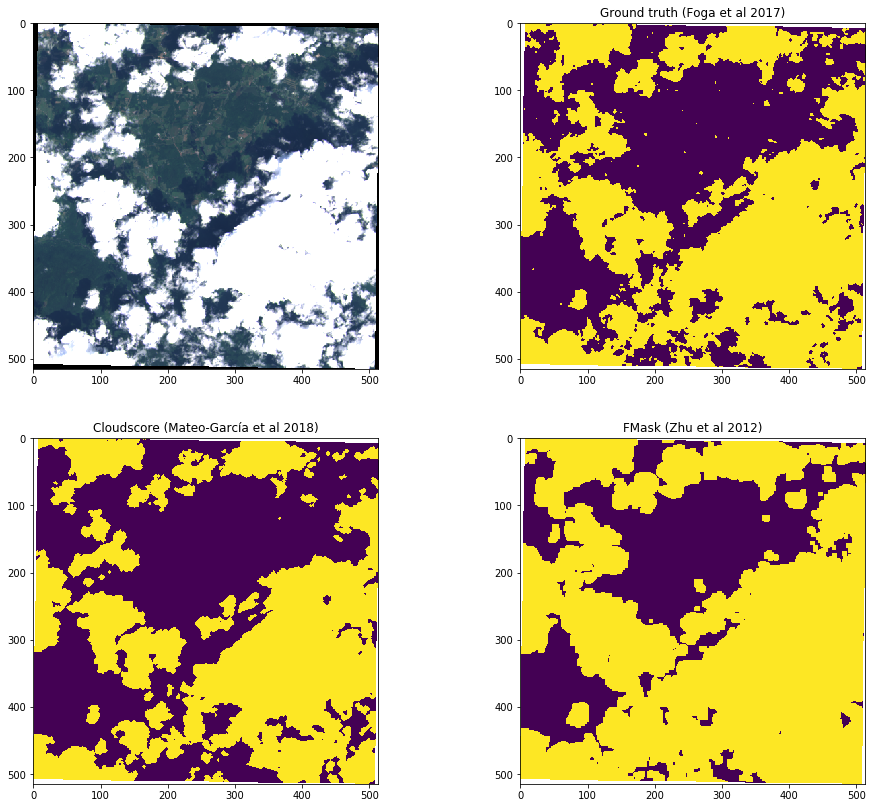

In [6]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,14))
ax1.imshow(np.clip(raster_img.memmap[...,(band_names.index("B4"),band_names.index("B3"),band_names.index("B2"))]/.3,0,1))
ax2.imshow(fixedmask)
ax2.set_title("Ground truth (Foga et al 2017)")
ax3.imshow(cloud_score)
ax3.set_title("Cloudscore (Mateo-García et al 2018)")
ax4.imshow(fmask)
_ = ax4.set_title("FMask (Zhu et al 2012)")

In [7]:
from sklearn.metrics import accuracy_score,confusion_matrix

mascara = np.ma.getmaskarray(fixedmask) | np.ma.getmaskarray(cloud_score) | np.ma.getmaskarray(fmask)
print(accuracy_score(np.ma.getdata(fixedmask)[~mascara],
               np.ma.getdata(cloud_score)[~mascara]))
accuracy_score(np.ma.getdata(fixedmask)[~mascara],
               np.ma.getdata(fmask)[~mascara])

0.9280400006206457


0.8528254899222641